In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#export
import sys
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/exp")
from nb_02 import *
import torch.nn.functional as F

# Initial Setup

## Data

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

In [0]:
n, m = x_train.shape
c= y_train.max() + 1
nh = 50

In [0]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh, n_out)]
    
  def __call__(self, x):
    for l in self.layers: x = l(x)
    return x

In [0]:
model = Model(m, nh, 10)

In [0]:
pred = model(x_train)

## Cross Entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$
or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$
In practice, we will need the log of the softmax when we calculate the loss.

In [0]:
def log_softmax(x):
  return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

In [0]:
sm_pred = log_softmax(pred)

In [12]:
pred, sm_pred

(tensor([[-0.0275,  0.0092, -0.2147,  ..., -0.0495, -0.0214,  0.0644],
         [-0.0113, -0.0682, -0.1864,  ...,  0.0903,  0.0189,  0.0840],
         [-0.1886, -0.0273, -0.1646,  ..., -0.0007,  0.1491,  0.0414],
         ...,
         [-0.1881, -0.1181, -0.1009,  ..., -0.0299,  0.0957,  0.0286],
         [-0.1767,  0.0650, -0.1534,  ..., -0.0832,  0.0837,  0.0529],
         [-0.2526, -0.0246, -0.1625,  ...,  0.0350,  0.0774, -0.0049]],
        grad_fn=<AddmmBackward>),
 tensor([[-2.2880, -2.2514, -2.4752,  ..., -2.3100, -2.2820, -2.1962],
         [-2.2901, -2.3470, -2.4652,  ..., -2.1885, -2.2599, -2.1948],
         [-2.4535, -2.2922, -2.4295,  ..., -2.2656, -2.1158, -2.2235],
         ...,
         [-2.4460, -2.3761, -2.3589,  ..., -2.2878, -2.1622, -2.2293],
         [-2.4478, -2.2061, -2.4245,  ..., -2.3543, -2.1874, -2.2182],
         [-2.5192, -2.2913, -2.4291,  ..., -2.2317, -2.1893, -2.2716]],
        grad_fn=<LogBackward>))

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$
But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style integer array indexing. Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [13]:
y_train[:3]

tensor([5, 0, 4])

In [14]:
sm_pred[[0,1,2],[5,0,4]], pred[[0,1,2],[5,0,4]]

(tensor([-2.3705, -2.2901, -2.3373], grad_fn=<IndexBackward>),
 tensor([-0.1099, -0.0113, -0.0724], grad_fn=<IndexBackward>))

In [15]:
y_train.shape

torch.Size([50000])

In [0]:
def nll(inp, target):
  return -inp[range(target.shape[0]), target].mean()

In [0]:
loss = nll(sm_pred, y_train)

In [18]:
loss

tensor(2.3075, grad_fn=<NegBackward>)

Note that the formula

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$
gives a simplification when we compute the log softmax, which was previously defined as (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [0]:
def log_softmax(x):
  return x - x.exp().sum(-1, keepdim=True).log()

In [0]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the LogSumExp trick. The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$
where a is the maximum of the $x_{j}$.

In [0]:
def logsumexp(x):
  m = x.max(-1)[0]
  return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us.

In [0]:
test_near(logsumexp(pred),pred.logsumexp(-1))

So we can use it for our log_softmax function.

In [0]:
def log_softmax(x):
  return x - x.logsumexp(-1, keepdim=True)

In [0]:
test_near(nll(log_softmax(pred), y_train), loss)

Then use PyTorch's implementation.

In [0]:
test_near(F.nll_loss(F.log_softmax(pred,-1), y_train), loss)

In PyTorch, F.log_softmax and F.nll_loss are combined in one optimized function, F.cross_entropy.

In [0]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop
Basically the training loop repeats over the following steps:



1.   get the output of the model on a batch of inputs
2.   compare the output to the labels we have and compute a loss
3.   calculate the gradients of the loss with respect to every parameter of the model
4.   update said parameters with those gradients to make them a little bit better

In [0]:
loss_func = F.cross_entropy

In [0]:
# export
def accuracy(out, yb):
  return (torch.argmax(out, dim=1) == yb).float().mean()

In [29]:
bs = 64
xb = x_train[0:bs]
pred = model(xb)
pred[0], pred.shape

(tensor([-0.0275,  0.0092, -0.2147,  0.0060, -0.0349, -0.1099, -0.0676, -0.0495,
         -0.0214,  0.0644], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [30]:
yb = y_train[0:bs]
loss_func(pred, yb)

tensor(2.3053, grad_fn=<NllLossBackward>)

In [31]:
accuracy(pred, yb)

tensor(0.0781)

In [0]:
lr = 0.5
epochs = 1

In [0]:
for epoch in range(epochs):
  for i in range((n-1)//bs+1):
    start_idx = i*bs
    end_idx = start_idx+bs
    xb = x_train[start_idx:end_idx]
    yb = y_train[start_idx:end_idx]
    loss = loss_func(model(xb), yb)
    
    loss.backward()
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l, 'weight'):
          l.weight -= l.weight.grad * lr
          l.bias -= l.bias.grad * lr
          l.weight.grad.zero_()
          l.bias.grad.zero_()

In [34]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1544, grad_fn=<NllLossBackward>), tensor(0.9375))

## Using Parameters and Optim
### Parameters
Use `nn.Module.__setattr__` and move relu to functional:

In [0]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)
    
  def __call__(self, x):
    return self.l2(F.relu(self.l1(x)))

In [0]:
model = Model(m, nh, 10)

In [37]:
for name, l in model.named_children():
  print(f'{name} : {l}')

l1 : Linear(in_features=784, out_features=50, bias=True)
l2 : Linear(in_features=50, out_features=10, bias=True)


In [38]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [39]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [0]:
def fit():
  for epoch in range(epochs):
    for i in range((n-1)//bs+1):
      start_idx = i*bs
      end_idx = start_idx + bs
      xb = x_train[start_idx:end_idx]
      yb = y_train[start_idx:end_idx]
      loss = loss_func(model(xb), yb)
      
      loss.backward()
      with torch.no_grad():
        for p in model.parameters():
          p -= p.grad * lr
          model.zero_grad()

In [41]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.3308, grad_fn=<NllLossBackward>), tensor(0.8750))

Behind the scenes, PyTorch overrides the `__setattr__` function in  nn.Module so that the submodules you define are properly registered as parameters of the model.


In [42]:
for p in model.parameters():
  print(f'{p.shape}')

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [0]:
class DummyModule():
  def __init__(self, n_in, nh, n_out):
    self._modules = {}
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)
    
  def __setattr__(self, k, v):
    if not k.startswith('_'):
      self._modules[k] = v
    super().__setattr__(k, v)
      
  def __repr__(self):
    return f'{self._modules}'
  
  def parameters(self):
    for l in self._modules.values():
      for p in l.parameters():
        yield p

In [44]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [45]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## Registering modules
We can use the original layers approach, but we have to register the modules.

In [46]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]
layers

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

In [0]:
class Model(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = layers
    for i, l in enumerate(self.layers):
      self.add_module(f'My_model_layer_{i}', l)
      
  def __call__(self, x):
    for l in self.layers:
      x = l(x)
      return x

In [48]:
model = Model(layers)
model

Model(
  (My_model_layer_0): Linear(in_features=784, out_features=50, bias=True)
  (My_model_layer_1): ReLU()
  (My_model_layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### `nn.ModuleList`


`nn.ModuleList` does this for us



In [0]:
class SequentialModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
    
  def __call__(self, x):
    for l in self.layers:
      x = l(x)
    return x
    

In [50]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [51]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.3393, grad_fn=<NllLossBackward>), tensor(0.8750))

### `nn.Sequential`
`nn.Sequential` is a convenient class which does the same as the above:

In [0]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [53]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.3767, grad_fn=<NllLossBackward>), tensor(0.8750))

In [0]:
nn.Sequential??

In [55]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim
Let's replace our previous manually coded optimization step:


```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```
and instead use just:



```
opt.step()
opt.zero_grad()
```





In [0]:
class Optimizer():
  def __init__(self, params, lr=0.5):
    self.params, self.lr = list(params), lr
    
  def step(self):
    with torch.no_grad():
      for p in self.params:
        p -= p.grad * lr
        
  def zero_grad(self):
    for p in self.params:
      p.grad.data.zero_()

In [0]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [0]:
opt = Optimizer(model.parameters())

In [0]:
for epoch in range(epochs):
  for i in range((n-1)//bs + 1):
    start_idx = i * bs
    end_idx = start_idx + bs
    xb = x_train[start_idx:end_idx]
    yb = y_train[start_idx:end_idx]
    pred = model(xb)
    loss = loss_func(pred, yb)
    
    loss.backward()
    opt.step()
    opt.zero_grad()

In [60]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2145, grad_fn=<NllLossBackward>), tensor(0.8750))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [0]:
# export
from torch import optim

In [0]:
optim.SGD.step??

In [0]:
def get_model():
  model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
  return model, optim.SGD(model.parameters(), lr= lr)

In [64]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.2815, grad_fn=<NllLossBackward>)

In [0]:
for epoch in range(epochs):
  for i in range((n-1)//bs + 1):
    start_idx = i * bs
    end_idx = start_idx + bs
    xb = x_train[start_idx:end_idx]
    yb = y_train[start_idx:end_idx]
    pred = model(xb)
    loss = loss_func(pred, yb)
    
    loss.backward()
    opt.step()
    opt.zero_grad()

In [66]:
loss_func(model(xb), yb) , accuracy(model(xb), yb)

(tensor(0.2113, grad_fn=<NllLossBackward>), tensor(0.8750))


Randomized tests can be very useful.

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:
```
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```    
Instead, let's do these two steps together, by introducing a Dataset class:

`xb,yb = train_ds[i*bs : i*bs+bs]`

In [0]:
# export
class Dataset():
  def __init__(self, x, y):
    self.x, self.y = x, y
  
  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, i):
    return self.x[i], self.y[i]


In [0]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [69]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28 * 28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [0]:
model, opt = get_model()

In [0]:
for epoch in range(epochs):
  for i in range((n-1)//bs + 1):
    xb, yb = train_ds[i * bs :  i*bs + bs]
    pred = model(xb)
    loss = loss_func(pred, yb)
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    

In [72]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.2106, grad_fn=<NllLossBackward>), tensor(0.9375))

### DataLoader
Previously, our loop iterated over batches (bx, yb) like this:

```
for i in range((n-1)//bs + 1):
  xb, yb = train_ds[i*bs : i*bs+bs]
  ...

```

Let's make our loop much cleaner, using a data loader

```
for xb, yb in train_dl:
  ...
```

In [0]:
class DataLoader():
  def __init__(self, ds, bs):
    self.ds, self.bs = ds, bs
    
  def __iter__(self):
    for i in range(0, len(self.ds), self.bs):
      yield self.ds[i:i+self.bs]

In [0]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [0]:
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs, 28 * 28)
assert yb.shape == (bs,)

tensor(3)

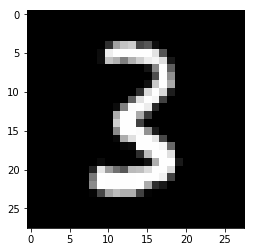

In [76]:
plt.imshow(xb[0].view(28, 28))
yb[0]

In [0]:
model, opt = get_model()

In [0]:
def fit():
  for epoch in range(epochs):
    for xb, yb in train_dl:
      pred = model(xb)
      loss = loss_func(pred, yb)
      loss.backward()
      opt.step()
      opt.zero_grad()

In [0]:
fit()

In [80]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1226, grad_fn=<NllLossBackward>), tensor(0.9688))

### Random Sampling


We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [0]:
class Sampler():
  def __init__(self, ds, bs, shuffle = False ):
    self.n, self.bs, self.shuffle = len(ds), bs, shuffle
    
  def __iter__(self):
    self.idx = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
    for i in range(0, self.n, self.bs):
      yield self.idx[i:i+self.bs]
    

In [0]:
small_ds = Dataset(*train_ds[:10])

In [83]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [84]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([7, 1, 0]), tensor([8, 2, 5]), tensor([6, 3, 4]), tensor([9])]

In [0]:
def collate(b):
  xs, ys = zip(*b)
  return torch.stack(xs), torch.stack(ys)


class DataLoader():
  def __init__(self, ds, sampler, collate_fn = collate):
    self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    
  def __iter__(self):
    for s in self.sampler:
      yield self.collate_fn([self.ds[i] for i in s])

In [0]:
train_sample = Sampler(train_ds, bs, shuffle = True)
valid_sample = Sampler(valid_ds, bs, shuffle = False)

In [0]:
train_dl = DataLoader(train_ds, sampler = train_sample, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler = valid_sample, collate_fn=collate) 

tensor(3)

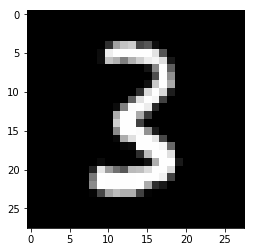

In [88]:
xb, yb =  next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(8)

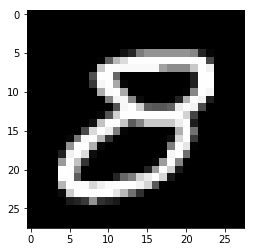

In [89]:
xb, yb =  next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [90]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0927, grad_fn=<NllLossBackward>), tensor(0.9844))

### PyTorch DataLoader

In [0]:
# export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [0]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [93]:
model, opt = get_model()
fit()
loss_func(model(xb), yb) , accuracy(model(xb), yb)

(tensor(0.5657, grad_fn=<NllLossBackward>), tensor(0.8906))

PyTorch's defaults work fine for most things however:

In [0]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [95]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.1032, grad_fn=<NllLossBackward>), tensor(0.9688))

## Validation


You **always** should also have a validation set, in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss = loss_func(model(xb), yb)
      loss.backward()
      opt.step()
      opt.zero_grad()
      
    model.eval()
    
    with torch.no_grad():
      tot_loss, tot_acc = 0., 0.
      for xb, yb in valid_dl:
        pred = model(xb)
        tot_loss += loss_func(pred, yb)
        tot_acc += accuracy(pred, yb)
        
        
    nv = len(valid_dl)
    print(epoch, tot_loss/nv, tot_acc/nv)
  return tot_loss/nv, tot_acc/nv
       

Question: Are these validation results correct if batch size varies?

get_dls returns dataloaders for the training and validation sets:

In [0]:
# export
def get_dls(train_ds, valid_ds, bs, **kwargs):
  return (DataLoader(train_ds, batch_size = bs, shuffle = True, **kwargs),
         DataLoader(valid_ds, batch_size = bs, shuffle = False, **kwargs))


In [98]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1645) tensor(0.9525)
1 tensor(0.1786) tensor(0.9491)
2 tensor(0.1253) tensor(0.9650)
3 tensor(0.1029) tensor(0.9701)
4 tensor(0.1104) tensor(0.9688)


## Export

In [99]:
!pip install fire

     |████████████████████████████████| 81kB 3.0MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=ebccbb3b88bf0c8ca93b3756f74d5305cb7087417188ca51b42ff1bd334c355b
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire


In [100]:
!python "/content/drive/My Drive/Colab Notebooks/notebook2script.py" "/content/drive/My Drive/Colab Notebooks/03_minibatch_training.ipynb"

Converted /content/drive/My Drive/Colab Notebooks/03_minibatch_training.ipynb to /content/drive/My Drive/Colab Notebooks/exp/nb_03.py
